##1. Setup (mount drive, install libraries, import packages, read_csv)

In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install pandas numpy matplotlib scikit-learn xgboost shap joblib
!pip install catboost lightgbm
!pip install dask[dataframe]

In [3]:


#packages for data handling
import pandas as pd
import numpy as np

#packages for data visualization
import matplotlib.pyplot as plt

#packages for preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

#packages for machine learning models
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

#package for evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

#package for interpretability
import shap

#package for saving/loading
import joblib


In [4]:
#defining column types to detect/prevent any rows with column misalignment
col_types = {'id': int,'Name': str,'Gender':str, 'Age': float, #Changed Age to float
             'City':str, 'Working Professional or Student': str,
             'Profession': str, 'Academic Pressure': float, 'Work Pressure': float, 'CGPA': float, 'Study Satisfaction': float,
             'Job Satisfaction': float, 'Sleep Duration': str, 'Dietary Habits': str, 'Degree': str, 'Have you ever had suicidal thoughts ?': str,
             'Work/Study Hours': float, 'Financial Stress': float, 'Depression': int}

#read in files from google drive
df_train = pd.read_csv('/content/drive/MyDrive/projects_jff/Forecasts/Kaggle_Depression/train.csv', dtype=col_types)
df_test = pd.read_csv('/content/drive/MyDrive/projects_jff/Forecasts/Kaggle_Depression/test.csv', dtype=col_types)

In [5]:
pd.set_option('display.max_columns', None)  # Display all columns
df_test.head()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

##2. Data Preprocessing

In [ ]:
# # Step 1: Get value counts
# profession_train_counts = df_train['Profession'].value_counts()
# # profession_test_counts = df_test_filtered['Profession'].value_counts()

# # Step 2: Filter degrees with counts >= 10
# valid_train_profession = profession_train_counts[profession_train_counts >= 10].index.tolist()
# # valid_test_profession = profession_test_counts[profession_test_counts >= 10].index.tolist()

# # Step 3: Filter the main dataset to keep only valid degrees
# df_train_filtered = df_train[df_train['Profession'].isin(valid_train_profession)]
# # df_test_filtered = df_test_filtered[df_test_filtered['Profession'].isin(valid_test_profession)]

In [ ]:
# Review missing data and decide to keep NaN or 0
# Most advanced models such as XGBoost, LightGBM, or CatBoost can manage NaN values
# Traditional or classical models such as Linear Regression, Logical Regression, or RandomForest cannot manage NaN

# We will build two datasets for both types of models or add new columns

# Features of interest
# Profession, Academic Pressure, Work Pressure, CGPA, Study Satisfaction, Job Satisfaction
# Dietary Habits, Degree, Financial Stress are a few rows/examples short of 140700 ~ we will fill missing values first

# Profession is the only categorical feature and will be encoded in a separate column for classical models to process
# All other features of interest will be filled with 0 ~ since these features are divided by working profession and student
# the models will recognize a 0 value will be associated with the appropriate class (professional vs. student)



###2.1 Managing missing values

In [6]:
#create a copy of the original df_train to avoid warnings and provide clarity
df_train_filtered_copy = df_train.copy()
df_test_filtered_copy = df_test.copy()

In [7]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def encode_categorical_features(train_df, test_df, features):
    """
    Encodes categorical features by:
    1. Handling NaN values (creates a binary column).
    2. Filling NaN values with 'unknown'.
    3. Label encoding (assigns unique integers).
    4. Frequency encoding.

    Parameters:
        train_df (pd.DataFrame): Training dataset.
        test_df (pd.DataFrame): Test dataset.
        features (list): List of categorical features to encode.

    Returns:
        train_df (pd.DataFrame): Updated training dataset.
        test_df (pd.DataFrame): Updated test dataset.
    """
    for feature in features:
        # Step 1: Create binary column for NaN values
        train_df[f"{feature}_nan"] = train_df[feature].isna().astype(int)
        test_df[f"{feature}_nan"] = test_df[feature].isna().astype(int)

        # Step 2: Replace NaN values with 'unknown'
        train_df[feature] = train_df[feature].fillna('unknown')
        test_df[feature] = test_df[feature].fillna('unknown')

        # Step 3: Label Encoding
        all_unique_values = pd.concat([train_df[feature], test_df[feature]]).unique()
        le = LabelEncoder()
        le.fit(all_unique_values)

        train_df[f"{feature}_encoded"] = le.transform(train_df[feature])
        test_df[f"{feature}_encoded"] = le.transform(test_df[feature])

        # Step 4: Frequency Encoding
        freq_counts = train_df[feature].value_counts(normalize=True)
        train_df[f"{feature}_frequency"] = train_df[feature].map(freq_counts)
        test_df[f"{feature}_frequency"] = test_df[feature].map(freq_counts)

    return train_df, test_df

In [8]:
df_train_filtered_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [10]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def encode_categorical_features(train_df, test_df, features):
    """
    Encodes categorical features by:
    1. Handling NaN values (creates a binary column).
    2. Filling NaN values with 'unknown'.
    3. Label encoding (assigns unique integers).
    4. Frequency encoding.

    Parameters:
        train_df (pd.DataFrame): Training dataset.
        test_df (pd.DataFrame): Test dataset.
        features (list): List of categorical features to encode.

    Returns:
        train_df (pd.DataFrame): Updated training dataset.
        test_df (pd.DataFrame): Updated test dataset.
    """
    for feature in features:
        # Check if the feature exists in both dataframes
        if feature in train_df.columns and feature in test_df.columns:
            # Step 1: Create binary column for NaN values
            train_df[f"{feature}_nan"] = train_df[feature].isna().astype(int)
            test_df[f"{feature}_nan"] = test_df[feature].isna().astype(int)

            # Step 2: Replace NaN values with 'unknown'
            train_df[feature] = train_df[feature].fillna('unknown')
            test_df[feature] = test_df[feature].fillna('unknown')

            # Step 3: Label Encoding
            all_unique_values = pd.concat([train_df[feature], test_df[feature]]).unique()
            le = LabelEncoder()
            le.fit(all_unique_values)

            train_df[f"{feature}_encoded"] = le.transform(train_df[feature])
            test_df[f"{feature}_encoded"] = le.transform(test_df[feature])

            # Step 4: Frequency Encoding
            freq_counts = train_df[feature].value_counts(normalize=True)
            train_df[f"{feature}_frequency"] = train_df[feature].map(freq_counts)
            test_df[f"{feature}_frequency"] = test_df[feature].map(freq_counts)

        elif feature in train_df.columns and feature not in test_df.columns:
            print(f"Feature '{feature}' is only present in the training dataset and will be skipped for the test dataset.")
            # Handle the feature only for the training dataset if needed
            # Step 1: Create binary column for NaN values
            train_df[f"{feature}_nan"] = train_df[feature].isna().astype(int)

            # Step 2: Replace NaN values with 'unknown'
            train_df[feature] = train_df[feature].fillna('unknown')

            # Step 3: Label Encoding
            all_unique_values = train_df[feature].unique()
            le = LabelEncoder()
            le.fit(all_unique_values)

            train_df[f"{feature}_encoded"] = le.transform(train_df[feature])

            # Step 4: Frequency Encoding
            freq_counts = train_df[feature].value_counts(normalize=True)
            train_df[f"{feature}_frequency"] = train_df[feature].map(freq_counts)

    return train_df, test_df

In [ ]:
# List of categorical features to encode
categorical_features = ['Name','Gender','City','Working Professional or Student','Profession',
                        'Sleep Duration','Dietary Habits','Degree','Have you ever had suicidal thoughts ?',
                        'Family History of Mental Illness','Depression']

# Apply the encoding function
df_train_filtered_copy, df_test_filtered_copy = encode_categorical_features(df_train_filtered_copy, df_test_filtered_copy, categorical_features)


In [12]:
#filling missing values of the following with 0
feat_list = ['Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Dietary Habits', 'Degree', 'Financial Stress']
df_train_filtered_copy[feat_list] = df_train_filtered_copy[feat_list].fillna(0) #vectorizing is more efficient than a for loop
df_test_filtered_copy[feat_list] = df_test_filtered_copy[feat_list].fillna(0)

In [17]:
#list of columns 2:22
feature_list = df_train_filtered_copy.columns[2:]

In [18]:
print(feature_list)

Index(['Gender', 'Age', 'City', 'Working Professional or Student',
       'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness', 'Depression', 'Name_nan',
       'Name_encoded', 'Name_frequency', 'Gender_nan', 'Gender_encoded',
       'Gender_frequency', 'City_nan', 'City_encoded', 'City_frequency',
       'Working Professional or Student_nan',
       'Working Professional or Student_encoded',
       'Working Professional or Student_frequency', 'Profession_nan',
       'Profession_encoded', 'Profession_frequency', 'Sleep Duration_nan',
       'Sleep Duration_encoded', 'Sleep Duration_frequency',
       'Dietary Habits_nan', 'Dietary Habits_encoded',
       'Dietary Habits_frequency', 'Degree_nan', 'Degree_encoded',
       'Degree_frequency', 'Have you 

##3. Exploratory Data Analysis (EDA)
Evaluate the balance of the dataset with visualization function.

Review any interesting features or anamolies.  

Make necessary balance adjustments to remove bias during training

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_value_counts(df, feature_list):
    """
    Plots the top 15 value counts for each feature in the given feature list.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the data.
        feature_list (list): List of feature (column) names to plot.

    Returns:
        None
    """
    for feature in feature_list:
        # Calculate the top 15 value counts
        top_values = df[feature].value_counts().head(15)

        # Create a bar plot
        plt.figure(figsize=(10, 6))
        sns.barplot(x=top_values.index, y=top_values.values, palette="viridis")

        # Customize the plot
        plt.title(f"Top 15 Value Counts for '{feature}'", fontsize=14)
        plt.xlabel(f"Values of {feature}", fontsize=12)
        plt.ylabel("Count", fontsize=12)
        plt.xticks(rotation=45, ha='right')

        # Show the plot
        plt.tight_layout()
        plt.show()

In [ ]:
plot_top_value_counts(df_train_filtered_copy, feature_list)

In [20]:
df_train_filtered_copy['Depression'].value_counts()

,count
Depression,
0,115133
1,25567


In [ ]:
df_train_filtered_copy['Financial Stress'].value_counts()

In [ ]:
#importing necessary packages for balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from collections import Counter

In [21]:
#preparing the data for SMOTEENN rebalancing of target variable "depression"
#create new dataframe for train and test and remove all string datatypes
clean_train = df_train_filtered_copy.drop(columns=['Name','Gender','City','Working Professional or Student','Profession',
                                                   'Sleep Duration','Dietary Habits','Degree','Have you ever had suicidal thoughts ?',
                                                   'Family History of Mental Illness'])

clean_test = df_test_filtered_copy.drop(columns=['Name','Gender','City','Working Professional or Student','Profession',
                                                   'Sleep Duration','Dietary Habits','Degree','Have you ever had suicidal thoughts ?',
                                                   'Family History of Mental Illness'])

In [22]:
clean_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 43 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   id                                               140700 non-null  int64  
 1   Age                                              140700 non-null  float64
 2   Academic Pressure                                140700 non-null  float64
 3   Work Pressure                                    140700 non-null  float64
 4   CGPA                                             140700 non-null  float64
 5   Study Satisfaction                               140700 non-null  float64
 6   Job Satisfaction                                 140700 non-null  float64
 7   Work/Study Hours                                 140700 non-null  float64
 8   Financial Stress                                 140700 non-null  float64
 9   Depression     

In [23]:
# Drop redundant versions of the target variable
columns_to_drop = ['Depression_nan', 'Depression_encoded', 'Depression_frequency']
clean_train = clean_train.drop(columns=columns_to_drop)

In [41]:
# Define feature matrix (X) and target variable (y)
X = clean_train.drop(columns=['id', 'Depression'])  # Drop ID and target variable
y = clean_train['Depression']

In [25]:
from imblearn.combine import SMOTEENN
from collections import Counter

# Initialize SMOTEENN
smoteenn = SMOTEENN(random_state=42)

# Apply SMOTEENN to balance the data
X_resampled, y_resampled = smoteenn.fit_resample(X, y)

# Print class distributions before and after resampling
print("Class distribution before resampling:", Counter(y))
print("Class distribution after resampling:", Counter(y_resampled))

Class distribution before resampling: Counter({0: 115133, 1: 25567})
Class distribution after resampling: Counter({1: 108363, 0: 89807})


In [46]:
# Check the shape of the resampled data
print("Resampled feature matrix shape:", X_resampled.shape)
print("Resampled target variable shape:", y_resampled.shape)

Resampled feature matrix shape: (198170, 38)
Resampled target variable shape: (198170,)


In [27]:
from sklearn.model_selection import train_test_split

# Split the balanced dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.2, random_state=42, stratify=y_resampled)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (158536, 38) (158536,)
Testing set shape: (39634, 38) (39634,)


##4. Model Training

###4.1 XGBoost

In [28]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Initialize and train XGBoost model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost
print("XGBoost Model Performance:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     17961
           1       0.99      0.99      0.99     21673

    accuracy                           0.99     39634
   macro avg       0.99      0.99      0.99     39634
weighted avg       0.99      0.99      0.99     39634



###4.2 Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest
print("Random Forest Model Performance:")
print(classification_report(y_test, y_pred_rf))

Random Forest Model Performance:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     17961
           1       0.99      0.99      0.99     21673

    accuracy                           0.99     39634
   macro avg       0.99      0.99      0.99     39634
weighted avg       0.99      0.99      0.99     39634



###4.3 LightGBM

In [30]:
from lightgbm import LGBMClassifier

# Initialize and train LightGBM model
lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

# Make predictions
y_pred_lgb = lgb_model.predict(X_test)

# Evaluate LightGBM
print("LightGBM Model Performance:")
print(classification_report(y_test, y_pred_lgb))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 86690, number of negative: 71846
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5213
[LightGBM] [Info] Number of data points in the train set: 158536, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546816 -> initscore=0.187814
[LightGBM] [Info] Start training from score 0.187814
LightGBM Model Performance:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     17961
           1       0.99      0.99      0.99     21673

    accuracy                           0.99     39634
   macro avg       0.99      0.99      0.99     39634
weighted avg       0.99      0.99      0.99     39634



##5. Evaluation of Models

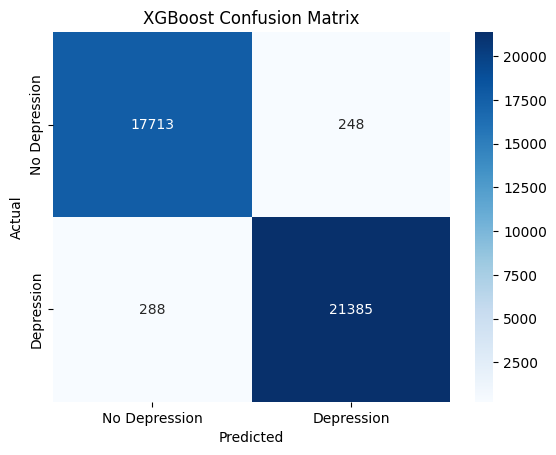

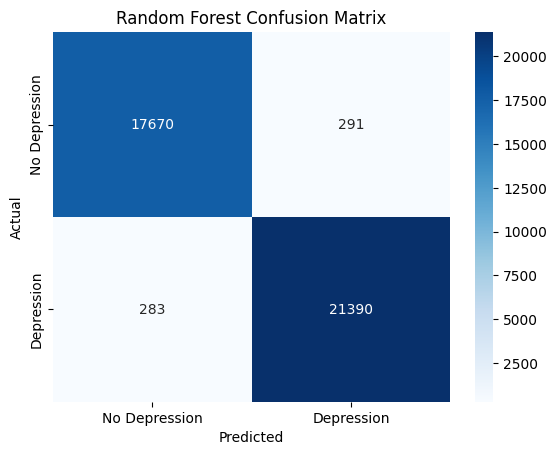

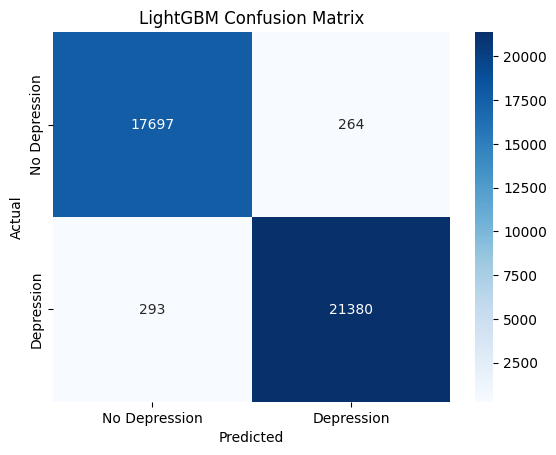

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Depression', 'Depression'],
                yticklabels=['No Depression', 'Depression'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_lgb, "LightGBM Confusion Matrix")

###5.2 Feature Importance

In [32]:
#XGBoost Feature Importance
importances = xgb_model.feature_importances_
features = X.columns

# Display feature importance
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                                            Feature  Importance
0                                               Age    0.426123
34  Have you ever had suicidal thoughts ?_frequency    0.134457
18          Working Professional or Student_encoded    0.114520
33    Have you ever had suicidal thoughts ?_encoded    0.046521
36         Family History of Mental Illness_encoded    0.037232
2                                     Work Pressure    0.035686
5                                  Job Satisfaction    0.030660
7                                  Financial Stress    0.022171
27                           Dietary Habits_encoded    0.022071
1                                 Academic Pressure    0.021902
22                             Profession_frequency    0.017663
28                         Dietary Habits_frequency    0.013378
25                         Sleep Duration_frequency    0.011675
21                               Profession_encoded    0.011379
37       Family History of Mental Illnes

In [33]:
#Random Forest Feature Importance
rf_importances = rf_model.feature_importances_
print(sorted(zip(features, rf_importances), key=lambda x: x[1], reverse=True))

[('Age', 0.2900584462118578), ('Profession_encoded', 0.1057142879253062), ('Profession_frequency', 0.10570212684339501), ('Working Professional or Student_frequency', 0.07240805762587856), ('Work Pressure', 0.04778489890152008), ('Academic Pressure', 0.044523091075778266), ('Working Professional or Student_encoded', 0.04390606619666872), ('Have you ever had suicidal thoughts ?_frequency', 0.042204233308099255), ('Job Satisfaction', 0.03237578394060689), ('Study Satisfaction', 0.0299655937437732), ('Financial Stress', 0.029031887094285204), ('CGPA', 0.0243447313821528), ('Degree_frequency', 0.0204828567120067), ('Work/Study Hours', 0.01810405271946405), ('Have you ever had suicidal thoughts ?_encoded', 0.01745270575009479), ('Dietary Habits_encoded', 0.010457632036345397), ('Dietary Habits_frequency', 0.00940628319177461), ('Sleep Duration_frequency', 0.008772719176751426), ('Family History of Mental Illness_frequency', 0.00690220625973134), ('Name_encoded', 0.0060414496074244215), ('Na

In [34]:
#LightGBM Feature Importance
lgb_importances = lgb_model.feature_importances_
print(sorted(zip(features, lgb_importances), key=lambda x: x[1], reverse=True))

[('Age', 367), ('Financial Stress', 324), ('Work Pressure', 260), ('Work/Study Hours', 238), ('Job Satisfaction', 228), ('Name_encoded', 157), ('Have you ever had suicidal thoughts ?_frequency', 125), ('Dietary Habits_encoded', 122), ('Academic Pressure', 120), ('Sleep Duration_frequency', 120), ('Dietary Habits_frequency', 118), ('Name_frequency', 113), ('Profession_frequency', 107), ('Profession_encoded', 102), ('Degree_encoded', 90), ('City_encoded', 74), ('Degree_frequency', 53), ('City_frequency', 52), ('Study Satisfaction', 38), ('Sleep Duration_encoded', 35), ('CGPA', 32), ('Have you ever had suicidal thoughts ?_encoded', 31), ('Family History of Mental Illness_frequency', 30), ('Family History of Mental Illness_encoded', 25), ('Gender_encoded', 21), ('Gender_frequency', 17), ('Working Professional or Student_encoded', 1), ('Name_nan', 0), ('Gender_nan', 0), ('City_nan', 0), ('Working Professional or Student_nan', 0), ('Working Professional or Student_frequency', 0), ('Professio

##6. Test Submission

In [35]:
import pandas as pd

# Assume df_test is your unseen test dataset
# Example structure: 'id' column + same features as training data

# 1. Preprocess the test dataset
# Ensure the test set only has the features used for training
test_ids = clean_test['id']  # Extract 'id' for the final output
X_test_unseen = clean_test.drop(columns=['id'])  # Drop 'id' for predictions

# The features in X_test_unseen must match the training set
print("Test Data Shape:", X_test_unseen.shape)

# 2. Make predictions on unseen data
y_pred_test = xgb_model.predict(X_test_unseen)

# If XGBoost outputs probabilities, convert them to class labels
# Uncomment the next line if needed:
# y_pred_test = (y_pred_test >= 0.5).astype(int)  # Convert probabilities to binary

# 3. Create the output DataFrame with 'id' and 'Depression'
output = pd.DataFrame({
    'id': test_ids,
    'Depression': y_pred_test
})

# 4. Save the output as a CSV file to google drive
output.to_csv('/content/drive/MyDrive/projects_jff/Forecasts/Kaggle_Depression/submission.csv', index=False)
# output.to_csv('submission.csv', index=False)  # Save the output
print("Output file saved as 'submission.csv'")

# Display the first few rows
print(output.head())

Test Data Shape: (93800, 38)
Output file saved as 'submission.csv'
       id  Depression
0  140700           0
1  140701           0
2  140702           0
3  140703           1
4  140704           0


##6.1 Ensemble Submission

In [ ]:
from sklearn.model_selection import train_test_split

# Split the balanced dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.2, random_state=42, stratify=y_resampled)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

In [47]:
# Define features (X) and target variable (y)
# X = clean_train.drop(columns=['id', 'Depression'])  # Drop irrelevant columns
# y = clean_train['Depression']  # Target variable

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

Training set shape: (158536, 38)
Validation set shape: (39634, 38)


In [48]:
# Initialize the models
xgb_model = XGBClassifier(random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
lgb_model = LGBMClassifier(random_state=42)

In [52]:
from sklearn.ensemble import VotingClassifier

# Create the ensemble model with soft voting
ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('lgb', lgb_model)
    ],
    voting='hard'  # 'soft' for probabilities; 'hard' for majority class
)

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Evaluate on the validation set
y_val_pred = ensemble_model.predict(X_val)
print("Ensemble Model Performance on Validation Set:")
print(classification_report(y_val, y_val_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 86690, number of negative: 71846
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5213
[LightGBM] [Info] Number of data points in the train set: 158536, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546816 -> initscore=0.187814
[LightGBM] [Info] Start training from score 0.187814
Ensemble Model Performance on Validation Set:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     17961
           1       0.99      0.99      0.99     21673

    accuracy                           0.99     39634
   macro avg       0.99      0.99      0.99     39634
weighted avg       0.99      0.99      0.99  

In [53]:
# Preprocess test dataset (ensure same features as training set)
test_ids = clean_test['id']  # Extract IDs for the final output
X_test = clean_test.drop(columns=['id'])  # Drop 'id'

# Predict the outcomes
y_test_pred = ensemble_model.predict(X_test)

# Create the output DataFrame
output = pd.DataFrame({
    'id': test_ids,
    'Depression': y_test_pred
})

# Save predictions to a CSV file to drive
output.to_csv('/content/drive/MyDrive/projects_jff/Forecasts/Kaggle_Depression/ensemble_predictions_hv.csv', index=False)

print("Predictions saved to 'ensemble_predictions.csv'.")
print(output.head())

Predictions saved to 'ensemble_predictions.csv'.
       id  Depression
0  140700           0
1  140701           0
2  140702           0
3  140703           1
4  140704           0


###6.2 LightGBM Submission

In [55]:
# Preprocess test dataset (ensure same features as training set)
test_ids = clean_test['id']  # Extract IDs for the final output
X_test = clean_test.drop(columns=['id'])  # Drop 'id'

# Initialize and train LightGBM model
lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)
# Predict the outcomes
y_test_pred = lgb_model.predict(X_test)

# Create the output DataFrame
output = pd.DataFrame({
    'id': test_ids,
    'Depression': y_test_pred
})

# Save predictions to a CSV file to drive
output.to_csv('/content/drive/MyDrive/projects_jff/Forecasts/Kaggle_Depression/lgbm_submission.csv', index=False)

print("Predictions saved to 'ensemble_predictions.csv'.")
print(output.head())

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 86690, number of negative: 71846
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5213
[LightGBM] [Info] Number of data points in the train set: 158536, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546816 -> initscore=0.187814
[LightGBM] [Info] Start training from score 0.187814
Predictions saved to 'ensemble_predictions.csv'.
       id  Depression
0  140700           0
1  140701           0
2  140702           0
3  140703           1
4  140704           0


###6.4 Random Forest Submission

In [56]:
# Preprocess test dataset (ensure same features as training set)
test_ids = clean_test['id']  # Extract IDs for the final output
X_test = clean_test.drop(columns=['id'])  # Drop 'id'

# Initialize and train LightGBM model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
# Predict the outcomes
y_test_pred = rf_model.predict(X_test)

# Create the output DataFrame
output = pd.DataFrame({
    'id': test_ids,
    'Depression': y_test_pred
})

# Save predictions to a CSV file to drive
output.to_csv('/content/drive/MyDrive/projects_jff/Forecasts/Kaggle_Depression/rf_submission.csv', index=False)

print("Predictions saved to 'ensemble_predictions.csv'.")
print(output.head())

Predictions saved to 'ensemble_predictions.csv'.
       id  Depression
0  140700           0
1  140701           0
2  140702           0
3  140703           1
4  140704           0


###6.4 Ensemble with only XGBoost and LightGBM

In [57]:
# Initialize the models
xgb_model = XGBClassifier(random_state=42)
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
lgb_model = LGBMClassifier(random_state=42)

In [58]:
from sklearn.ensemble import VotingClassifier

# Create the ensemble model with soft voting
ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        # ('rf', rf_model),
        ('lgb', lgb_model)
    ],
    voting='soft'  # 'soft' for probabilities; 'hard' for majority class
)

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Evaluate on the validation set
y_val_pred = ensemble_model.predict(X_val)
print("Ensemble Model Performance on Validation Set:")
print(classification_report(y_val, y_val_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 86690, number of negative: 71846
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5213
[LightGBM] [Info] Number of data points in the train set: 158536, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546816 -> initscore=0.187814
[LightGBM] [Info] Start training from score 0.187814
Ensemble Model Performance on Validation Set:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     17961
           1       0.99      0.99      0.99     21673

    accuracy                           0.99     39634
   macro avg       0.99      0.99      0.99     39634
weighted avg       0.99      0.99      0.99  

In [59]:
# Preprocess test dataset (ensure same features as training set)
test_ids = clean_test['id']  # Extract IDs for the final output
X_test = clean_test.drop(columns=['id'])  # Drop 'id'

# Predict the outcomes
y_test_pred = ensemble_model.predict(X_test)

# Create the output DataFrame
output = pd.DataFrame({
    'id': test_ids,
    'Depression': y_test_pred
})

# Save predictions to a CSV file to drive
output.to_csv('/content/drive/MyDrive/projects_jff/Forecasts/Kaggle_Depression/ensemble_predictions_sv_norf.csv', index=False)

print("Predictions saved to 'ensemble_predictions.csv'.")
print(output.head())

Predictions saved to 'ensemble_predictions.csv'.
       id  Depression
0  140700           0
1  140701           0
2  140702           0
3  140703           1
4  140704           0
